In [1]:
import pandas as pd
# import gzip
import numpy as np
# import json
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df_train = pd.read_csv('vlsp_sentiment_train.csv', sep=',')
df_test = pd.read_csv('vlsp_sentiment_test.csv', sep=',')

# Data preprocessing

In [4]:
pd.set_option('max_colwidth', 150)
df_train.head()

,Class,Data
0,-1,"Mình đã dùng anywhere thế hệ đầu, quả là đầy thất vọng, hiện tại đang vứt xó. Giá thì đắt, ngốn pin như ăn gỏi, nặng"
1,-1,"Quan tâm nhất là độ trễ có cao không, dùng thi thoảng nó cứ trễ bực mình, đấy mới chỉ là dùng văn phòng chứ game thì chắc là ném đi từ lâu. Không ..."
2,-1,"dag xài con cùi bắp 98k....pin trâu, mỗi tội đánh liên minh ức chế đập hết 2 con"
3,-1,logitech chắc hàng phải tiền triệu trở lên dùng mới thích chứ em dùng con có 400k thấy được vài bữa là hư. chuyển sang eblue dùng được hơn năm chư...
4,-1,"Đang xài con m175 cùi mía , nhà xài nhiều chuột nên thử con này con kia chơi và kết quả là sau 3 tháng và 4 con chuột khác nhau đủ kiểu đa chức nă..."


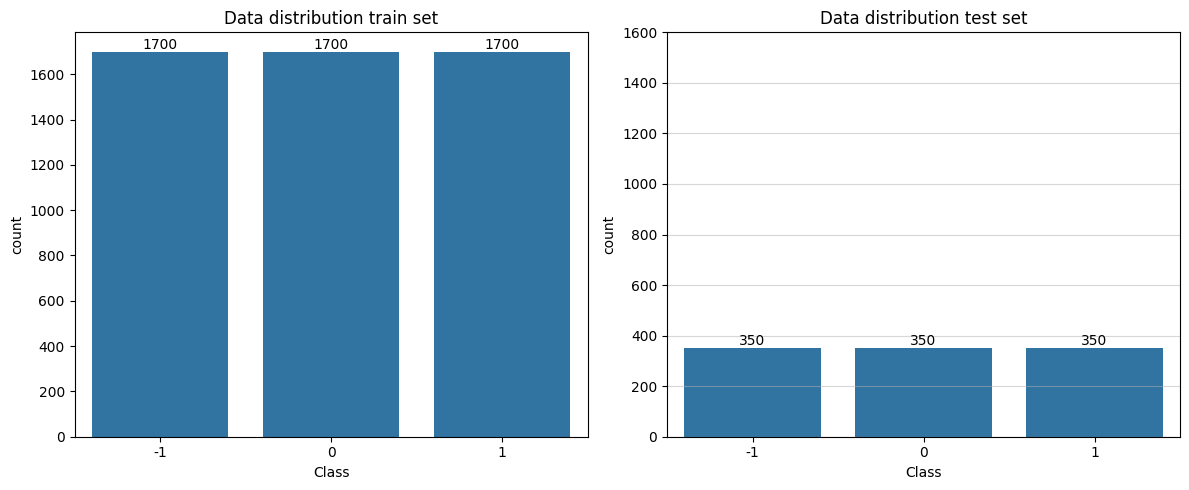

In [5]:
fig, ax = plt.subplots(1,2, figsize=(12,5)) 

sns.countplot(x='Class', data=df_train, ax = ax[0])
ax[0].bar_label(ax[0].containers[0])
ax[0].set_xlabel('Class')
ax[0].set_ylabel('count')
ax[0].set_title('Data distribution train set')

sns.countplot(x='Class', data=df_test, ax = ax[1])
ax[1].bar_label(ax[1].containers[0])
ax[1].set_xlabel('Class')
ax[1].set_ylabel('count')
ax[1].set_title('Data distribution test set')
ax[1].set_ylim(bottom=0, top = 1600)
plt.tight_layout()
plt.grid(visible=True,axis='y',alpha=0.5)
plt.show()

In [21]:
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torch
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
import re
import time
import pickle
from tqdm import tqdm
from nltk.tokenize import RegexpTokenizer
from pyvi import ViTokenizer

In [7]:
with open('vietnamese-stopwords.txt', 'r', encoding='utf-8') as file:
    stopwords = file.read()
def clean_text(text):
    # remove hyperlinks
    text = re.compile(r'^https?://', re.IGNORECASE).sub(r'', text)
    # remove numbers
    text = re.sub("[0-9]", " ", text)
    # remove punctuation
    text = RegexpTokenizer(r'\w+').tokenize(text)
    text = " ".join(text)
    # # remove stopwords
    # text = ViTokenizer.tokenize(text)
    # text = text.split()
    # text = [w for w in text if not w in stopwords.split('\n')]
    # text = " ".join(text)
    return text  

In [8]:
df_train['Data'] = df_train['Data'].apply(clean_text)
df_test['Data'] = df_test['Data'].apply(clean_text)

In [9]:
df_train.head(10)

,Class,Data
0,-1,Mình đã dùng anywhere thế hệ đầu quả là đầy thất vọng hiện tại đang vứt xó Giá thì đắt ngốn pin như ăn gỏi nặng
1,-1,Quan tâm nhất là độ trễ có cao không dùng thi thoảng nó cứ trễ bực mình đấy mới chỉ là dùng văn phòng chứ game thì chắc là ném đi từ lâu Không biế...
2,-1,dag xài con cùi bắp k pin trâu mỗi tội đánh liên minh ức chế đập hết con
3,-1,logitech chắc hàng phải tiền triệu trở lên dùng mới thích chứ em dùng con có k thấy được vài bữa là hư chuyển sang eblue dùng được hơn năm chưa th...
4,-1,Đang xài con m cùi mía nhà xài nhiều chuột nên thử con này con kia chơi và kết quả là sau tháng và con chuột khác nhau đủ kiểu đa chức năng mà h c...
5,-1,Đang xài con M nút chuột giữa hai con đều như hạch xài chưa được năm scroll đã chạy bậy rồi Hay mua phải đồ đểu hỉ
6,-1,Con Anywhere mình dùng bị double click cũng lần rồi chán lắm
7,-1,Hàng cty cấp cấp xong vứt ở nhà xài con Xornet cho đỡ mỏi tay Cơ mà vẫn thắc mắc là dong thấp nhất nhưng éo bằng con misumi giá bằng
8,-1,Magic mouse mà ngon hơn mới lạ Magic mouse chỉ được cái đẹp pin thì ăn tuần hết không di trên mọi bề mặt được bạn nhé bảo hành thì hãng bảo hành n...
9,-1,em giống y bác luôn chán bluetooth kinh hồn tr mà em không tưởng tượng được độ chuối của bluetooth


Ultility functions used to tokenize sentences

input = "I got an ice cream"

tokenize_output = ["I", "got", "an", "ice", "cream"]

In [10]:
from torchtext.vocab import build_vocab_from_iterator
import torchtext.transforms as T

def tokenize(data):
    for x in data:
        yield ViTokenizer.tokenize(x.lower()).split()

In [11]:
vocab = build_vocab_from_iterator(
    tokenize(pd.concat([df_train['Data'], df_test['Data']])),
    min_freq=1,
    specials= ['<pad>', '<sos>', '<eos>', '<unk>'],
    special_first=True
)
vocab.set_default_index(vocab['<unk>'])


In [18]:
vocabsize = len(vocab)
print(vocab.get_itos()[:45])
print(vocabsize)

['<pad>', '<sos>', '<eos>', '<unk>', 'không', 'là', 'thì', 'có', 'mình', 'được', 'của', 'và', 'mua', 'mà', 'dùng', 'cái', 'này', 'cũng', 'hơn', 'quá', 'với', 'cho', 'con', 'bạn', 'nó', 'rồi', 'nhưng', 'còn', 'như', 'thấy', 'giá', 'em', 'chỉ', 'phải', 'gì', 'để', 'đẹp', 'rất', 'các', 'máy', 'ra', 'mới', 'đã', 'nên', 'lại']
8804


Function to transform dataset into vectors given the vocabulary

In [12]:
def getTransform(vocab):
    """
    Create transforms based on given vocabulary. The returned transform is applied to sequence
    of tokens.
    """
    text_tranform = T.Sequential(
        ## converts the sentences to indices based on given vocabulary
        T.VocabTransform(vocab=vocab),
        ## Add <sos> at beginning of each sentence. 1 because the index for <sos> in vocabulary is
        # 1 as seen in previous section
        T.AddToken(1, begin=True),
        ## Add <eos> at beginning of each sentence. 2 because the index for <eos> in vocabulary is
        # 2 as seen in previous section
        T.AddToken(2, begin=False)
    )
    return text_tranform
def applyTransform(text):
    """
    Apply transforms to sequence of tokens in a sequence pair
    """

    return getTransform(vocab)(ViTokenizer.tokenize(text.lower()).split())


In [13]:
x_train = df_train['Data'].apply(applyTransform)
x_test = df_test['Data'].apply(applyTransform)

In [14]:
y_train = []
y_test = []
label_train = df_train['Class'].values
label_test = df_test['Class'].values
for x in label_train:
    if x == -1:
        y_train.append([1,0,0])
    elif x == 0:
        y_train.append([0,1,0])
    elif x == 1:
        y_train.append([0,0,1])

for y in label_test:
    if y == -1:
        y_test.append([1,0,0])
    elif y == 0:
        y_test.append([0,1,0])
    elif y == 1:
        y_test.append([0,0,1])


In [15]:
print(x_train[0])
print(x_test[0])

[1, 8, 42, 14, 1354, 607, 310, 652, 5, 613, 478, 409, 54, 839, 2949, 30, 6, 294, 1014, 47, 28, 8597, 477, 2]
[1, 87, 779, 5, 8, 6, 6, 361, 69, 8, 17, 157, 3496, 32, 632, 123, 40, 2439, 8, 54, 833, 22, 617, 3017, 53, 9, 230, 24, 66, 1940, 1653, 516, 703, 251, 53, 9, 2018, 230, 68, 24, 66, 362, 308, 2617, 73, 50, 22, 204, 4452, 8, 53, 83, 41, 66, 1940, 1653, 11, 4433, 308, 2617, 2]


In [16]:
print(y_train)

[[1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0]

In [29]:
# Define the dimensions
input_dim = vocabsize # The dimension of your input data (e.g., vocabulary size)
hidden_dim = 512 # Size of the hidden layer
embedding_dim =  300
output_dim = 3  # Two classes: positive and negative
learning_rate = 0.001
epochs = 100
batch_size = 128

Use device GPU for training

In [43]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU available. Using GPU.")
else:
    device = torch.device("cpu")
    print("GPU not available. Using CPU.")
print(device)

GPU available. Using GPU.
cuda


The LSTM model, with the following structure:

- Word Embedding Layer
- 3 LSTM layer
- 1 fully connected layer
- Dropout layer

In [44]:
# Define the classification model
class SentimentClassifier(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim):
        super(SentimentClassifier, self).__init__()
        self.hidden_dim = hidden_dim
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        # self.embedding.weight = nn.Parameter(embedding_matrix.clone().detach())
        self.conv = nn.Conv1d(embedding_dim, hidden_dim, kernel_size=3)
        # self.conv1 = nn.Conv1d(embedding_dim, hidden_dim, kernel_size=4)
        # self.conv2 = nn.Conv1d(embedding_dim, hidden_dim, kernel_size=5)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(0.5)
        # self.sm = nn.LogSoftmax(dim=1)

    def forward(self, text, length):
        """text dim: padded sequence object with max length = length"""
        embedded = self.embedding(text)
        embedded = embedded.permute(0, 2, 1)
        out = F.relu(self.conv(embedded))
        # out1 = F.relu(self.conv1(embedded))
        # out2 = F.relu(self.conv2(embedded))

        out = F.max_pool1d(out, out.size(2)).squeeze(2)
        # out1 = F.max_pool1d(out1, out1.size(2)).squeeze(2)
        # out2 = F.max_pool1d(out2, out2.size(2)).squeeze(2)

        # concat = torch.cat([out, out1, out2], dim=1)
        o = self.fc(out)
        o = self.dropout(o)
        # o = self.sm(o)
        return o

Dataset class (for pytorch)

In [23]:
class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        """This function is called everytime we iterate through the dataloader"""
        # sample = {'data': self.data[idx], 'label': self.labels[idx]}
        return self.data.iloc[idx], self.labels[idx]



Data with different length vectors cannot be passed into an LSTM layer directly. To enable processing of variable-length sequences, padding is applied to ensure all vectors within a batch have the same length. For instance:

Original data:
```
data = [
    torch.tensor([16]),
    torch.tensor([204, 185, 65, 345]), 
    torch.tensor([204, 987]),
    torch.tensor([85, 4, 23])
]
```

Padded batch:
```
tensor([
    [ 16,   0,   0,   0], 
    [204, 185,  65, 345], 
    [204, 987,   0,   0], 
    [ 85,   4,  23,   0]
])
```

In this example, the vectors have been padded with zeros to match the length of the longest sequence within the batch, enabling their use in sequence-based models like LSTMs.

In [24]:
def custom_collate_fn(batch):
    data, labels = zip(*batch)

    # Sort sequences by length (from longest to shortest)
    sorted_data, sorted_labels = zip(*sorted(zip(data, labels), key=lambda x: len(x[0]), reverse=True))
    # Pad sequences to the length of the longest sequence
    padded_data = pad_sequence([torch.tensor(seq) for seq in sorted_data], batch_first=True)
    padded_labels = torch.tensor(sorted_labels).float()

    # Create a mask for the padded elements
    mask = (padded_data != 0).float()

    return padded_data.to(device), mask, padded_labels.to(device)

Intialize dataset and dataloader

In [25]:
torch.manual_seed(12)
trainset = CustomDataset(x_train, y_train)
testset = CustomDataset(x_test, y_test)

# trainset = CustomDataset(vocab_train, y_train_onehot)
# testset = CustomDataset(vocab_test, y_test)

# Create a DataLoader for your dataset
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, collate_fn=custom_collate_fn)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=True, collate_fn=custom_collate_fn)


Model, Loss function and optimizer initilaization

In [45]:
# Instantiate the classifier
model = SentimentClassifier(input_dim, embedding_dim, hidden_dim, output_dim).to(device)
# Define the loss function (cross-entropy) and the optimizer (Adam)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
softmax = nn.Softmax(dim=1)

RuntimeError: CUDA error: the launch timed out and was terminated
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
for x,y,z in train_loader:
    print(x)
    print('AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA')
    print(y)
    print('AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA')
    print(z)
    print('AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA')
    # seq_unpacked, lens_unpacked = pad_packed_sequence(x, batch_first=True)
    # print(seq_unpacked)
    break

Try predicting without training

In [39]:
for x,y,z in test_loader:
    predictions = model(x,y)
    loss = criterion(predictions,z)
    # loss.backward()
    print(loss.item())
    
    predictions = softmax(predictions)
    predictions = torch.argmax(predictions, dim=1)
    true_label = torch.argmax(z, dim=1)
    result = predictions==true_label
    print(predictions)
    print(true_label)
    print(result)
    print(f"{result.float().mean()*100}%")
    break

1.356655240058899
tensor([1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0,
        1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1,
        0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1,
        1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 2, 1, 1, 2,
        0, 1, 1, 1, 0, 0, 1, 1], device='cuda:0')
tensor([2, 1, 2, 0, 2, 2, 2, 1, 1, 0, 1, 2, 1, 2, 1, 1, 2, 0, 0, 1, 1, 0, 2, 1,
        0, 0, 0, 1, 0, 2, 2, 1, 2, 1, 1, 2, 2, 2, 1, 1, 0, 2, 1, 0, 1, 1, 1, 0,
        0, 0, 2, 2, 1, 2, 2, 0, 1, 2, 2, 1, 0, 1, 0, 1, 1, 1, 2, 0, 0, 2, 1, 1,
        2, 0, 1, 1, 0, 1, 2, 1, 0, 2, 1, 0, 1, 2, 1, 0, 1, 2, 1, 0, 0, 0, 1, 2,
        0, 0, 0, 0, 2, 2, 0, 2, 1, 0, 0, 2, 1, 2, 1, 1, 2, 1, 0, 2, 1, 1, 0, 0,
        2, 2, 2, 2, 0, 2, 2, 2], device='cuda:0')
tensor([False,  True, False, False, False, False, False,  True,  True, False,
    

Training loop and Testing loop

In [40]:
def trainloop(trainloader):
    epoch_train_loss = 0.0
    model.train()
    with tqdm(trainloader, unit="batch", desc='Training: ') as tbatch:
        for data, mask, labels in tbatch:
            optimizer.zero_grad()
            output = model(data, mask)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss
            tbatch.set_postfix(loss="{:.6f}".format(loss)) #loss of a batch
    return epoch_train_loss/len(trainloader) #loss accross the train set

def evaluateloop(testloader):
    model.eval()
    accuracy_tensor = torch.empty(0).to(device)
    with tqdm(testloader, unit="batch", desc='Evaluating: ') as ttest:
        with torch.no_grad():
            for data, mask, labels in ttest:
                predictions = model(data, mask)
                predictions = softmax(predictions)
                predictions = torch.argmax(predictions, dim=1)
                true_label = torch.argmax(labels, dim=1)
                batch_accuracy = predictions==true_label #accuracy of a single batch
                accuracy_tensor = torch.cat((accuracy_tensor, batch_accuracy), dim=0) #accuracy accoss test set
                ttest.set_postfix({'accuracy': batch_accuracy.float().mean().item()})
    accuracy = accuracy_tensor.float().mean()
    return accuracy

Function to save model in case of interuption and resume training from file

In [41]:
def checkpoint(model, optimizer, loss, epoch, filename):
    torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
        }, filename)
def resume(filename):
    checkpoint = torch.load(filename)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    return loss

In [42]:
start_time = time.time()
torch.manual_seed(0)
last_lost = 0.0 #the lost of the last epoch to determine stopping point
patience = 3 
trigger_times = 0 #counter for early stop
stop = False
start_epoch=0
curr_epoch = 0
delta = 0.01
counter = 0
try:
    with open('loss_values.pkl', 'rb') as f_loss, open('accuracy_values.pkl', 'rb') as f_accuracy:
        loss_array = pickle.load(f_loss)
        accuracy_array = pickle.load(f_accuracy)
except FileNotFoundError:
    # If files don't exist, initialize empty arrays
    loss_array = [] #used for graphing loss changes throughout training
    accuracy_array = [] 


if start_epoch>0:
    print("Found existing checkpoint, continue training")
    last_lost = resume(f'Model_at_epoch_{start_epoch}.pth')

try:
    for epoch in range(start_epoch, epochs):
        curr_epoch = epoch
        #Train
        train_loss = trainloop(train_loader)

        #Test
        accuracy = evaluateloop(test_loader)
        accuracy_array+=[accuracy]
        loss_array+=[train_loss]

        if counter%5==0:
            with open('loss_values.pkl', 'wb') as f_loss, open('accuracy_values.pkl', 'wb') as f_accuracy:
                pickle.dump(loss_array, f_loss)
                pickle.dump(accuracy_array, f_accuracy)

        counter+=1
        # Print statistics at the end of each epoch
        print(f'Epoch [{epoch+1}/{epochs}] | Test Accuracy: {accuracy:.2%} | Current Loss: {train_loss: .6f} | Delta = {abs(train_loss - last_lost)}\n')
        #Early stopping check
        if abs(train_loss - last_lost)<=delta:
            trigger_times+=1
        elif abs(train_loss - last_lost)>delta:
            trigger_times=0
        if trigger_times>=patience:
            stop = True
        last_lost=train_loss
        if stop == True:
            break
except KeyboardInterrupt:
    print("Training interrupted. Saving current model checkpoint.")
    checkpoint(model, optimizer, loss_array[-1], curr_epoch+1, f'Model_at_epoch_{curr_epoch+1}.pth')
    with open('loss_values.pkl', 'wb') as f_loss, open('accuracy_values.pkl', 'wb') as f_accuracy:
        pickle.dump(loss_array, f_loss)
        pickle.dump(accuracy_array, f_accuracy)

# Print total training time
print("Total training time: {:.2f} seconds".format(time.time() - start_time))
#Save model
checkpoint(model, optimizer, loss_array[-1], curr_epoch+1, f'Model_at_epoch_{curr_epoch+1}.pth')
with open('loss_values.pkl', 'wb') as f_loss, open('accuracy_values.pkl', 'wb') as f_accuracy:
    pickle.dump(loss_array, f_loss)
    pickle.dump(accuracy_array, f_accuracy)


Training:   8%|▊         | 3/40 [00:10<02:06,  3.41s/batch, loss=3.058986]


RuntimeError: GET was unable to find an engine to execute this computation

Create some sentences for testing

In [24]:
resume("Model_at_epoch_17.pth")

tensor(0.0016, device='cuda:0', requires_grad=True)

Loss and Accuracy graph

[0.5428571105003357, 0.5552380681037903, 0.5685714483261108, 0.6114285588264465, 0.6085714101791382, 0.6361904740333557, 0.6333333253860474, 0.6190476417541504, 0.6276190280914307, 0.5971428751945496, 0.6323809623718262, 0.6133333444595337, 0.630476176738739, 0.6180952191352844, 0.6285714507102966, 0.6352381110191345]
[1.068518877029419, 0.9620057344436646, 0.8905289769172668, 0.8232842683792114, 0.7608823180198669, 0.688190758228302, 0.6125331521034241, 0.5605904459953308, 0.4983657896518707, 0.4910115897655487, 0.4593185484409332, 0.41459304094314575, 0.38103270530700684, 0.3732811212539673, 0.3758256137371063, 0.37173911929130554]


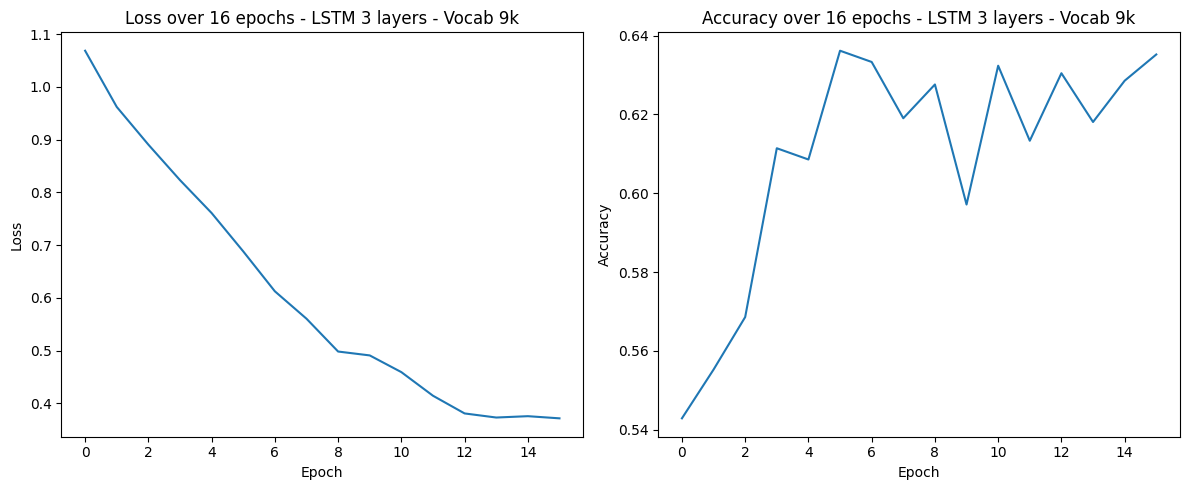

In [93]:
with open('accuracy_values.pkl', 'rb') as acc:
    acc_array = pickle.load(acc)
with open('loss_values.pkl', 'rb') as loss:
    loss_arrray = pickle.load(loss)
print(acc_array)
print(loss_arrray)
epoch = range(len(loss_arrray))

for i, x in enumerate(loss_arrray):
    loss_arrray[i] = x.item()
for i, x in enumerate(acc_array):
    acc_array[i] = x.item()
    
fig, ax = plt.subplots(1,2, figsize=(12,5)) 

ax[0].plot(epoch, loss_arrray)
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].set_title(f'Loss over {len(loss_arrray)} epochs - LSTM 3 layers - Vocab 9k')

ax[1].plot(epoch, acc_array)
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].set_title(f'Accuracy over {len(acc_array)} epochs - LSTM 3 layers - Vocab 9k')
plt.tight_layout()
plt.show()

In [82]:
model.eval()

# Collect predictions and true labels
prediction_list = []
true_labels = []

with torch.no_grad():
    for x,y,z in test_loader:
        predictions = model(x,y)
        predictions = softmax(predictions)
        predictions = torch.argmax(predictions, dim=1)
        true_label = torch.argmax(z, dim=1)
        prediction_list.extend(predictions.cpu().numpy())
        true_labels.extend(true_label.cpu().numpy())
        # break
print(len(prediction_list))
print(len(true_labels))

1050
1050


In [83]:
prediction_list = np.array(prediction_list)
true_labels = np.array(true_labels)
label_map = {0: "Negative", 1: "Neutral", 2: "Positive"}
prediction_list = np.array([label_map[label] for label in prediction_list])
true_labels = np.array([label_map[label] for label in true_labels])


Classification report: 
               precision    recall  f1-score   support

    Negative       0.61      0.65      0.63       350
     Neutral       0.62      0.55      0.58       350
    Positive       0.68      0.71      0.69       350

    accuracy                           0.64      1050
   macro avg       0.63      0.64      0.63      1050
weighted avg       0.63      0.64      0.63      1050



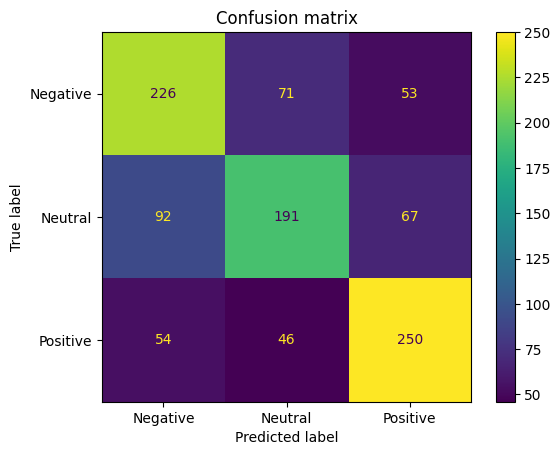

In [84]:
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, multilabel_confusion_matrix

print("Classification report: \n", classification_report(true_labels, prediction_list))
mcm = multilabel_confusion_matrix(true_labels, prediction_list)
disp = ConfusionMatrixDisplay.from_predictions(y_true=true_labels,y_pred=prediction_list)
plt.title("Confusion matrix")
plt.show()